# BMEN4480 Assignment 2 
## Author: Lauren Friend (lef2148) Collaborators: [Cameron Park]

In [1]:
# imports
import matplotlib
import matplotlib.pyplot as plt
import gzip
import pandas as pd
import sklearn
import scanpy as sc
import scipy
import numpy as np
import os
import anndata
import statistics
import seaborn as sns
sns.set_style("whitegrid")
import bhtsne
import phenograph

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


### Load Data

In [2]:
path=os.getcwd()
PBMC6k_path = f"{path}/pbmc_6Kcells_500genes.txt"
PBMC6k = pd.read_csv(PBMC6k_path,sep='\t')

In [3]:
cellid= pd.DataFrame(PBMC6k['CELLID'])
cellid_T = cellid.transpose()
PBMC6k = PBMC6k.drop(columns='CELLID')
PBMC6k_T = PBMC6k.transpose()

In [4]:
print(f"matrix shapes genesXcells format: {PBMC6k.shape} and {cellid.shape}")
print(f"transposed matrix shapes cellsXgenes format: {PBMC6k_T.shape} and {cellid_T.shape}")

matrix shapes genesXcells format: (500, 6825) and (500, 1)
transposed matrix shapes cellsXgenes format: (6825, 500) and (1, 500)


### Global Normalization

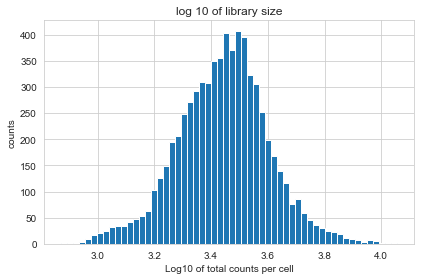

In [5]:
# Distrbution of library size (total counts per cell) 
counts_log10 = np.log10(PBMC6k_T.sum(axis=1))
plt.hist(counts_log10,bins='auto')
plt.title('log 10 of library size')
plt.xlabel('Log10 of total counts per cell')
plt.ylabel('counts')
plt.tight_layout()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


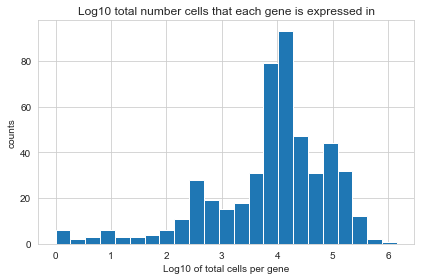

In [6]:
counts_log10 = np.log10(PBMC6k_T.sum(axis=0))
plt.hist(counts_log10,bins='auto', range=(0,counts_log10.max()))
plt.title('Log10 total number cells that each gene is expressed in')
plt.xlabel('Log10 of total cells per gene')
plt.ylabel('counts')
plt.tight_layout()

In [10]:
#normalizing the data & taking log10 
ms = PBMC6k_T.sum(axis=1) #library size
norm_df = PBMC6k_T.div(ms, axis=0).mul(np.median(ms), axis=0) 
log_df = np.log(0.1+ norm_df)

## Q1a
Log transform the data and performPCA,followed by t-SNE or UMAP on the top 20 PCs. Plot the 2D or 3D embedding [15pt].

In [11]:
#perform PCA with 20 PC's
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
pca_projections = pd.DataFrame(pca.fit_transform(log_df),
                index=log_df.index)

In [12]:
#t-SNE on the top 20 PC's
tsne = pd.DataFrame(bhtsne.tsne(pca_projections, perplexity=30), 
            index=log_df.index, columns=['x', 'y'])

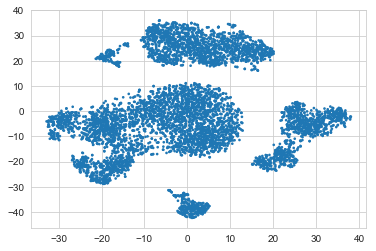

In [13]:
#plotting the 2D embedding
plt.scatter(tsne['x'], tsne['y'], s=7, edgecolors='none' )

## Q1b. 
Is 20 a good choice for the number of PCs? [bonus 5 pt]

    Yes, however from the exploratory line graph below you can see that the kneepoint is lower than 20. I would choose ~15 for the number of PC's 

In [15]:
#perform PCA with a larger number of PCs
pca_test = PCA(n_components=50)
pca_test.fit(log_df.values)

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

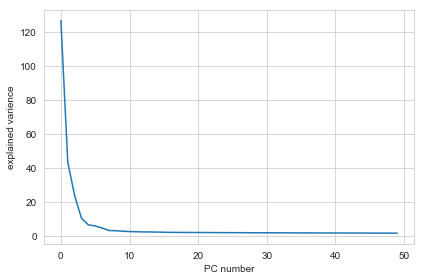

In [16]:
# Get Eiganvectors
eig_vectors = pca_test.components_
# Get Eiganvalues
eig_values = pca_test.explained_variance_
# plot
plt.plot(eig_values)
plt.xlabel('PC number')
plt.ylabel('explained varience')
plt.tight_layout()

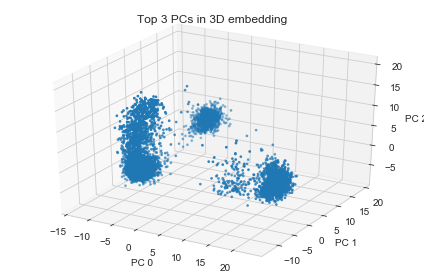

In [17]:
from mpl_toolkits.mplot3d import Axes3D
# Plot initialisation
colors=['r','g','b']
fig=plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_projections[0], pca_projections[1], pca_projections[2], s=3, cmap='sprectral')
ax.set_xlabel('PC 0')
ax.set_ylabel('PC 1')
ax.set_zlabel('PC 2')
ax.set_title('Top 3 PCs in 3D embedding')
fig.tight_layout()

## Q2.
Cluster cells using the K-means method and color the embedding from Q1 with clusterIDs. Justify your choice of K 

In [23]:
from sklearn.cluster import KMeans
kmeans_5 = KMeans(n_clusters=5, random_state=0,algorithm="full").fit_predict(pca_projections)
kmeans_10 = KMeans(n_clusters=10, random_state=0,algorithm="full").fit_predict(pca_projections)
kmeans_15 = KMeans(n_clusters=15, random_state=0,algorithm="full").fit_predict(pca_projections)
kmeans_20 = KMeans(n_clusters=20, random_state=0,algorithm="full").fit_predict(pca_projections)

In [24]:
kmeans_5_df = pd.DataFrame(kmeans_5,index=tsne.index)
kmeans_10_df = pd.DataFrame(kmeans_10,index=tsne.index)
kmeans_15_df = pd.DataFrame(kmeans_15,index=tsne.index)
kmeans_20_df = pd.DataFrame(kmeans_20,index=tsne.index)

In [25]:
kmeans_results=[kmeans_5,kmeans_10,kmeans_15,kmeans_20]
kmeans_dataframes=[kmeans_5_df,kmeans_10_df,kmeans_15_df,kmeans_20_df]

In [21]:
def plot_kmeans(kmeans,kmeans_df, num):
    for i,cluster in enumerate(set(kmeans)):
        cells=kmeans_df.index[kmeans==cluster]
        ax[num].scatter(tsne.loc[cells,'x'],tsne.loc[cells,'y'],edgecolors='none',label=cluster,s=3)
        ax[num].set_title(f'{clusters[num]} clusters',fontsize=20)
        ax[num].legend()

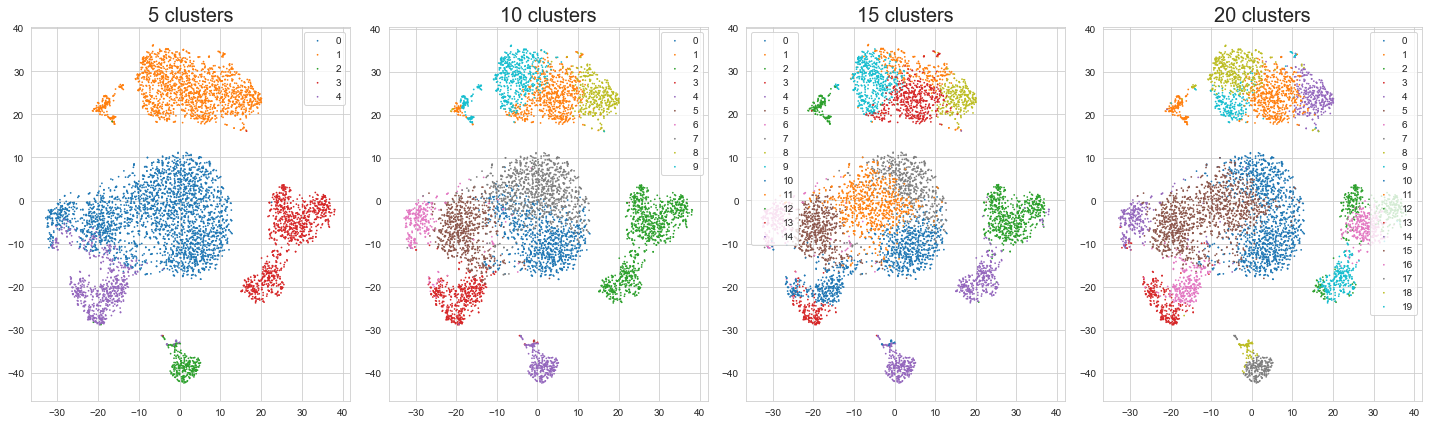

In [26]:
clusters=[5,10,15,20]
fig, ax = plt.subplots(1,4,figsize=(5*4,6))
num=0
for kmeans_data,datafr in zip(kmeans_results,kmeans_dataframes):
    plot_kmeans(kmeans_data,datafr,num)
    num+=1
fig.tight_layout()

In [27]:
#test different genes and see if genes that should be coexpressed are expressed in same cluster and genes that should not be coexpressed are not coexpressed

## Q3
Compute a 30-NN(nearestneighbor)graph between cells. Plot a heat map of the adjacency matrix for the graph [10 pts]. Justify your distance metric [bonus 5 pts].

In [28]:
from sklearn.neighbors import kneighbors_graph
knn_minkowski = kneighbors_graph(log_df,n_neighbors=30,mode='distance', metric='euclidean') #sparse weight matrix
knn_manhattan = kneighbors_graph(log_df,n_neighbors=30,p=1,mode='distance',metric='euclidean') #sparse weight matrix
knn_euclidian = kneighbors_graph(log_df,n_neighbors=30,p=2,mode='distance',metric='euclidean') #sparse weight matrix

In [29]:
knn_minkowski_graph = pd.DataFrame(knn_minkowski.todense()) #DF of dense weight matrix
knn_manhattan_graph = pd.DataFrame(knn_manhattan.todense()) #DF of dense weight matrix
knn_euclidian_graph = pd.DataFrame(knn_euclidian.todense()) #DF of dense weight matrix

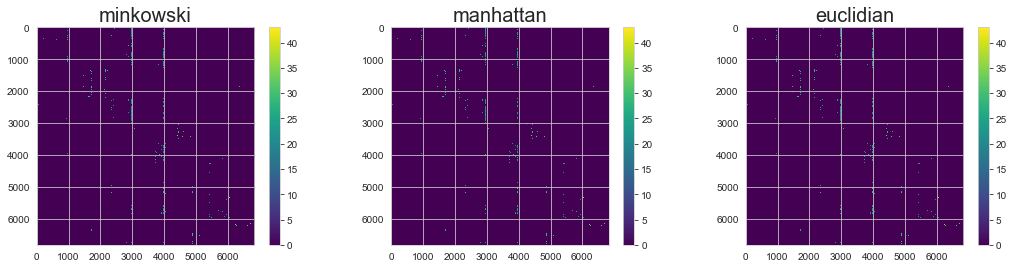

In [48]:
titles=['minkowski','manhattan','euclidian']
fig, axs = plt.subplots(1,3,figsize=(6*3,4))
axs=axs.ravel()
for i, metric in enumerate([knn_minkowski_graph,knn_manhattan_graph,knn_euclidian_graph]):
    j=axs[i].imshow(metric,cmap='viridis')
    axs[i].set_title(titles[i],fontsize=20)
    plt.colorbar(j, ax=axs[i])
    

## Q4
Cluster cells using a graph-based algorithm such as Louvain with the kNN graph from Q3. Color the embedding with cluster IDs. How does it compare to K-means? [20 pts]

In [53]:
communities, graph, Q = phenograph.cluster(knn_manhattan_graph,k=20) #manhattan distance

Finding 20 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 72.9910888671875 seconds
Jaccard graph constructed in 1.4685618877410889 seconds
Wrote graph to binary file in 0.508281946182251 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.798794
Louvain completed 21 runs in 1.3211078643798828 seconds
PhenoGraph complete in 76.30847406387329 seconds


In [54]:
communities = pd.Series(communities,index=log_df.index)

In [55]:
max(communities)

11

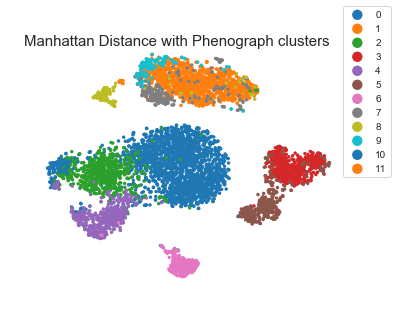

In [56]:
fig1, ax = plt.subplots(1,1, figsize=(5,4))
for i, cluster in enumerate(set(communities)):
    cells = communities.index[communities == cluster]
    #plot with a different color for each cluster
    ax.scatter(tsne.loc[cells, 'x'], tsne.loc[cells,'y'], 
            s=12,edgecolors='none', label=cluster)

    # Clean up
    ax.set_axis_off()
    sns.despine()

leg = fig1.legend(loc=1, markerscale=3)
bb= leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
xOffset = .03
bb.x0 += xOffset
bb.x1 += xOffset
leg.set_bbox_to_anchor(bb, transform = ax.transAxes)
fig1.suptitle("Manhattan Distance with Phenograph clusters",fontsize=15)
fig1.tight_layout()

In [122]:
communities, graph, Q = phenograph.cluster(knn_euclidian_graph,k=30) #euclidian distance

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 87.41453528404236 seconds
Jaccard graph constructed in 1.950685977935791 seconds
Wrote graph to binary file in 0.6807632446289062 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.884814
Louvain completed 21 runs in 1.9268438816070557 seconds
PhenoGraph complete in 91.995854139328 seconds


In [123]:
communities = pd.Series(communities,index=log_df.index)

In [124]:
max(communities)

16

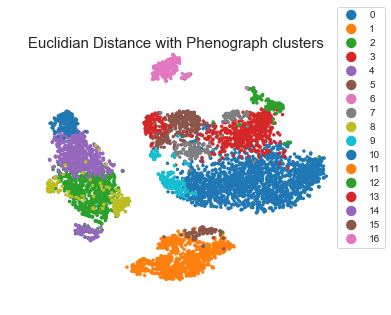

In [127]:
fig1, ax = plt.subplots(1,1, figsize=(5,4))
for i, cluster in enumerate(set(communities)):
    cells = communities.index[communities == cluster]
    #plot with a different color for each cluster
    ax.scatter(tsne.loc[cells, 'x'], tsne.loc[cells,'y'], 
            s=12,edgecolors='none', label=cluster)

    # Clean up
    ax.set_axis_off()
    sns.despine()

leg = fig1.legend(loc=1, markerscale=3)
bb= leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
xOffset = .03
bb.x0 += xOffset
bb.x1 += xOffset
leg.set_bbox_to_anchor(bb, transform = ax.transAxes)
fig1.suptitle("Euclidian Distance with Phenograph clusters",fontsize=15)
fig1.tight_layout()

## Q5a.
Perform a t-test to find differentially expressed genes(DEGs)in a cluster of your choice. Color the embedding with the expression of the top 5 DEGs [20 pts]

In [155]:
log_cluster_0_df=log_df.loc[communities.index[communities == 0]] #log transformed df of phenograph cluster 0
log_cluster_others_df=log_df.loc[communities.index[communities != 0]] #log transformed df of clusters 1:16

In [164]:
test,pval = scipy.stats.ttest_ind(log_cluster_0_df,log_cluster_others_df, axis=0, equal_var=True)

In [254]:
top5_test=np.argsort(test)[-5:]

In [255]:
top5=list(top5_test)
top5.reverse()
for gene_id in top5:
    print(cellid.iloc[gene_id][0])

TRAC
CD3E
LDHB
CD3D
RPL31


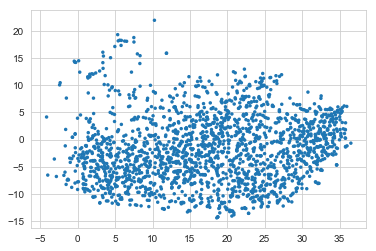

In [258]:
#graph of cluster 0
cells=communities.index[communities == 0]

plt.scatter(tsne.loc[cells, 'x'], tsne.loc[cells,'y'], 
            s=12,edgecolors='none')

In [263]:
gene_expression=log_cluster_0_df[471]

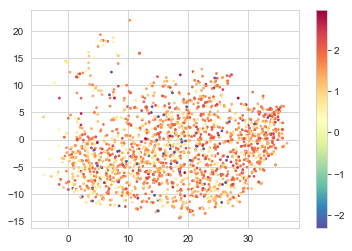

In [267]:
plt.scatter(tsne.loc[cells, 'x'], tsne.loc[cells,'y'], s=3, cmap=matplotlib.cm.Spectral_r, c=gene_expression,label='TRAC')
plt.colorbar()

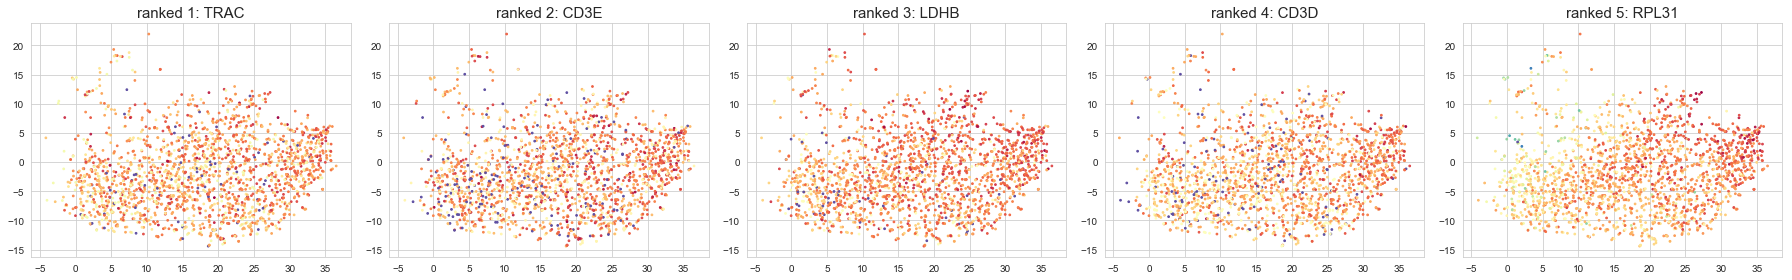

In [287]:
fig, ax = plt.subplots(1,5,figsize=(5*5,4))
for i,gene in enumerate(top5):
    gene_expression=log_cluster0_df[gene]
    ax[i].scatter(tsne.loc[cells, 'x'], tsne.loc[cells,'y'], s=3, cmap=matplotlib.cm.Spectral_r, c=gene_expression)
    ax[i].set_title(f"Ranked {i+1}: {cellid.iloc[gene][0]}",fontsize=15)
fig.tight_layout()

In [ ]:
## plot this in the whole graph because this should be bright in cluster 0 and dark everywhere else 

## Q5b. 
How would you characterize the cluster [5 pts]?

## Q5c.
Which other differential expression method might be appropriate for the expression distribution in this data? [bonus 15pt]